# Water Quality Classification Using Machine Learning Algorithms 
=======================================================================================================================

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore
from warnings import filterwarnings
# Suppress warnings
filterwarnings('ignore')


In [2]:
# Importing the dataset
df = pd.read_csv("water_dataX.csv", encoding= 'unicode_escape')
# This encoding is often used for files that contain characters outside of the ASCII range
df = df.iloc[0:1900, :]
df.shape

(1900, 12)

In [3]:
# Checking for datatypes of the dataset
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [4]:
df.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [5]:
# Changing column names
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

### Converting object data type to numeric

In [6]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
        # The errors="coerce" parameter tells Pandas to convert non-numeric values to NaN (Not a Number) instead of raising an error.
    return df

df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

### Replacing string NAN values with actual NAN value (np.nan)

In [7]:
def convert_to_nan(df):
    n_col = df.shape[1] 
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [8]:
# Checking for missing values
df.isnull().sum().sort_values()

year              0
PH                7
Conductivity     24
DO               30
BOD              42
Temp             89
STATION CODE    120
Tot_col         130
LOCATIONS       183
NI              189
Fec_col         280
STATE           670
dtype: int64

         Since I have 1991 training examples, I can replace each missing value with median of the column (to avoid outliers)

In [9]:
# Replacing NULL values with median of column
# Selecting numeric data
df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num) # fit_transform method is used to fit the imputer to your data and simultaneously apply the transformation.
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [10]:
# Filling Categorical missing values
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum()

STATION CODE    120
LOCATIONS       183
STATE           670
dtype: int64

In [11]:
# Here we can fill these values by obeserving other attributes
# Example - 
pd.set_option('mode.chained_assignment', None)  # we're essentially suppressing any warnings or errors related to chained 
                   # assignments. This means that Pandas will allow chained assignments without issuing warnings or errors.

df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
# Station Code with value 1330 will have Location - TAMBIRAPARANI which belongs in STATE - TAMIL NADU
# I can replace all the NAN occurences in STATE with TAMILNADU
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [12]:
# The NULL values in LOCATION attribute are in STATE attribute (ex - above dataframe)
# So, I will fill the NULL values in LOCATION attribute with the corresponding STATE value
# And, the state value will be replaced by the function "fill_state" defined below this cell

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [13]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [14]:
# Now I can fill NULL values of Station code with corresponding LOCATION value(ex - above dataframe)
# I will match the corresponding LOCATION value with other same LOCATION value and insert the value of station code

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [15]:
# Filling all state NAN values which have corresponding station code value
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [16]:
df_cat_copy.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [17]:
df_cat_copy[df_cat_copy["STATE"].isnull()]
# we'll get a DataFrame containing only the rows where the "STATE" column has a null value. 

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


##### The above are the missing values which are left and does not satisfy any condition
So, according to the location these values will be filled manually

In [18]:
# The first location KABBANI AT MUTHANKARA is in STATE Kerela
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

In [19]:
df_cat = df_cat_copy
df_cat.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
dtype: int64

In [20]:
df_num.isnull().sum()

Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [21]:
df_final = pd.concat([df_cat, df_num], axis=1)
# oncatenates two DataFrames, df_cat and df_num
df_final.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [22]:
# These are the samples which don't contain any attribute
# The filled attributes are median of corresponding columns
# So it is best to remove them
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
260,NaN,NaN,NaN,27.0,6.7,7.3,198.0,1.8965,0.52,233.0,465.0,2013.0
431,NaN,NaN,NaN,27.0,6.7,7.3,198.0,1.8965,0.52,233.0,465.0,2013.0


In [23]:
df_final.isnull().sum()

STATION CODE    0
LOCATIONS       0
STATE           0
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [24]:
df_final.shape

(1898, 12)

The final dataset contains 1988 samples and 12 attributes

# EDA

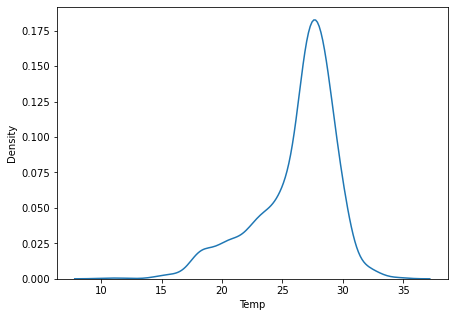

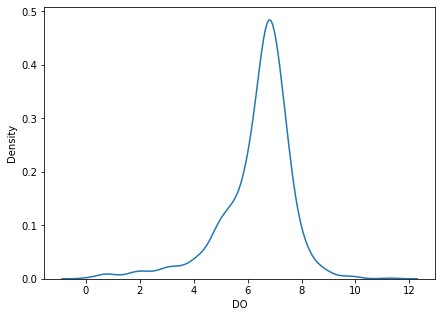

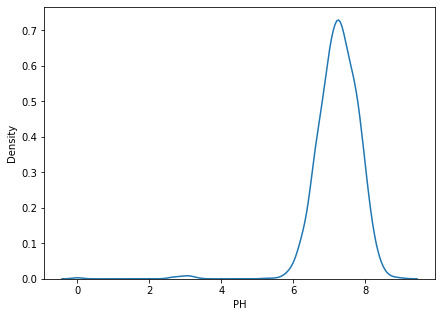

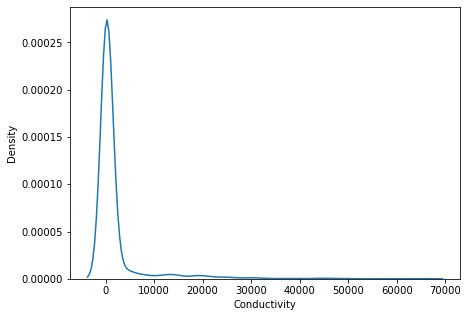

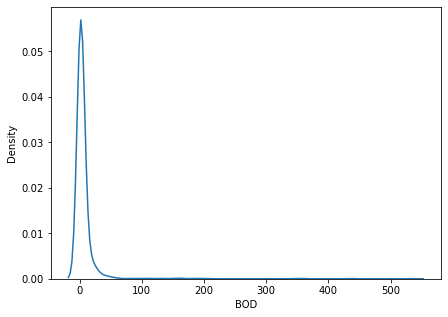

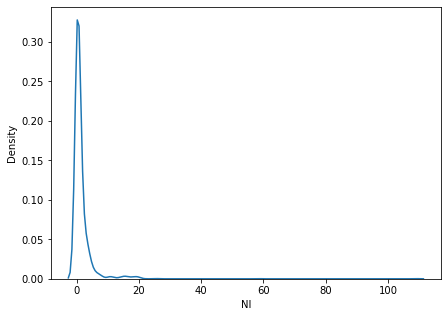

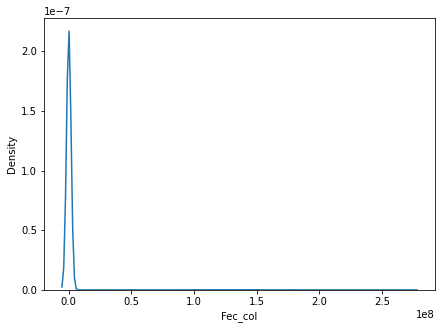

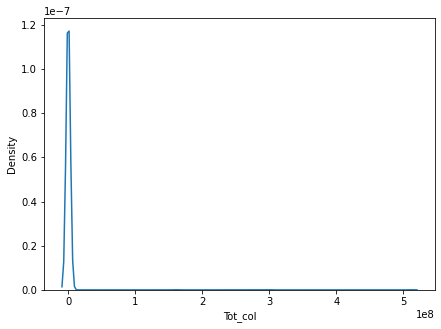

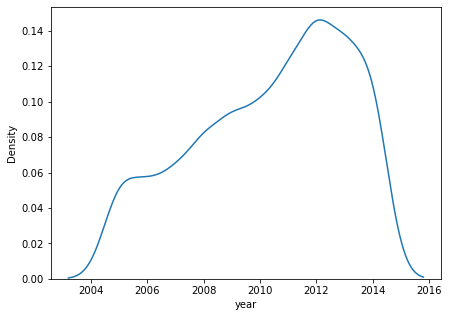

In [25]:
# PLotting PDFs(probability density functions) of all the numeric attributes in the dataset

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [26]:
# Here, almost all kde plots are Gaussian Like 
# Using Z-Score Normalization to detect outliers

df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method- 125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.52,233.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.52,233.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [27]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1785, 12)

## Water Quality Index Calculation

I will be using "Weighted Arithmetic Water Quality Index Method" to calculate WQI of each water sample. The formula to calculate WQI is - 

**WQI = ∑ qi × wi / ∑ wi**

Here wi - Unit weight of ith parameter

     qi - Quality estimate scale of each parameter, it is calculated with the formula - 

**qi = 100 × ( Vi − VIdeal / Si − VIdeal )**

Here Vi - Measured value of ith parameter

     Videal - Ideal value of ith parameter in pure water
     
     Si - Standard value recommended for ith parameter

wi is calculated by the formula - 

**wi = K /  Si**

Here K is proportionality constant which is - 

 **K = 1 /  ∑ Si**

##### Standard value recommended for parameters (Si) - 

Dissolved oxygen, mg/L               10

pH                                   8.5

Conductivity, µS/cm                  1000

Biological oxygen demand, mg/L       5

Nitrate, mg/L                        45

Fecal coliform/100 mL                100

Total coliform/100 mL                1000

##### Values of unit weights for each parameter (wi) - 

Dissolved Oxygen                     0.2213

pH                                   0.2604

Conductivity                         0.0022

Biological Oxygen Demand             0.4426

Nitrate                              0.0492

Fecal Coliform                       0.0221

Total Coliform                       0.0022

##### Ideal value of parameters (Videal) - 

Dissolved Oxygen                     14.6

pH                                   7.0

Conductivity                         0

Biological Oxygen Demand             0

Nitrate                              0

Fecal Coliform                       0

Total Coliform                       0

### Calculating Water Quality Index of each sample

In [28]:
# Calculating Water Quality Index of each sample
df_num_final = df_final.select_dtypes(exclude="object")
# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Weight Vector(wi)
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample): 
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

### Computing WQI for the whole dataset

In [29]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [30]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [31]:
# Combining dataframe of WQI and dataframe of attributes 
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1785, 13)

In [32]:
# These are samples with negative WQI
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.5,6.7,2.7,1350.0,3.3000,1.10,7.0,16.0,2014.0,-6.855044
231,2,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,27.0,6.7,0.0,208.0,1.8965,0.52,233.0,465.0,2013.0,-61.372099
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,27.0,6.7,0.0,506.0,1.8965,6.00,26.0,227.0,2013.0,-65.334452
446,3375,LUKHA RIVER,MEGHALAYA,21.3,6.8,2.7,1074.0,3.2000,2.33,4.0,11.0,2013.0,-8.214971
719,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.0,6.9,2.6,1072.0,3.2000,1.17,3.0,21.0,2012.0,-10.579224


In [33]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

##### Now I will set level of water contamination based on WQI -

          WQI Range                   Classification

         Less than 25                  Excellent(3)
            26–50                         Good(2)
            51-75                         Poor(1)
        Greater than 75                 Very Poor(0)

In [34]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (3 if (x <= 25)
                                        else(2 if (26<=x<=50)
                                        else(1 if (51<=x<=75)
#                                         else(0 if (76<=x<=100)
                                        else 0))))

In [35]:
df_wqi.tail()

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.0,7.4,7.00,88.5,0.977,0.186,27.0,105.0,2005.0,43.946271,2
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.675,0.263,40.0,191.0,2005.0,77.315135,0
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.091,0.256,151.0,273.0,2005.0,69.053768,1
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.092,0.520,404.0,513.0,2005.0,74.670773,1
1784,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",TRIPURA,30.0,5.4,7.37,104.8,1.802,0.215,456.0,557.0,2005.0,76.881207,0


In [36]:
df_wqi.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,26.241931,6.432263,7.228045,1006.325691,3.961788,1.119716,2264.420646,7242.598876,2010.380337,130.303409,0.715169
std,3.231044,1.258875,0.582761,2764.600752,7.130494,1.629483,8259.474360,40230.193629,2.704223,222.261326,0.731754
min,10.000000,0.000000,2.900000,11.000000,0.100000,0.000000,0.000000,0.000000,2005.000000,16.795814,0.000000
25%,25.000000,6.000000,6.900000,83.000000,1.100000,0.263000,46.000000,108.750000,2008.000000,54.641036,0.000000
50%,27.000000,6.700000,7.224500,183.000000,1.800000,0.520000,233.000000,465.000000,2011.000000,69.840286,1.000000
75%,28.200000,7.200000,7.600000,489.250000,3.400000,1.100000,672.500000,1650.000000,2013.000000,94.348696,1.000000
max,35.000000,10.000000,9.010000,18569.000000,88.000000,13.200000,150250.000000,967500.000000,2014.000000,3524.421534,3.000000


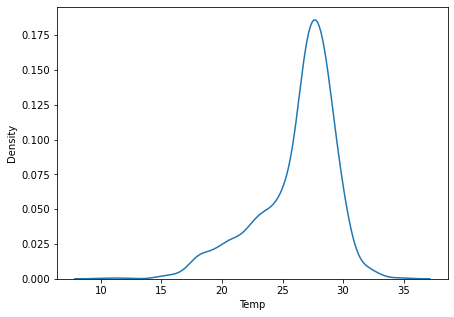

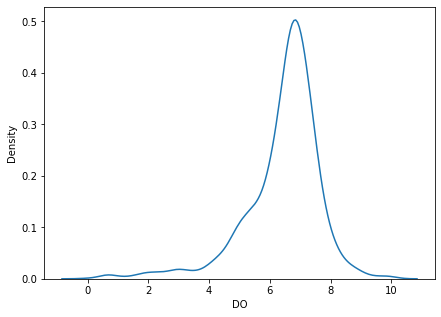

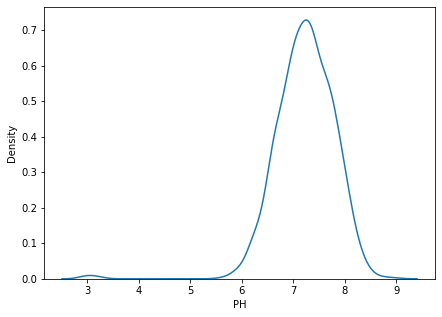

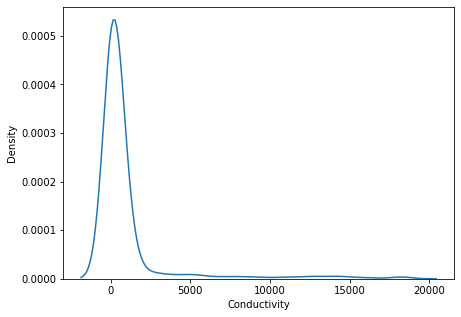

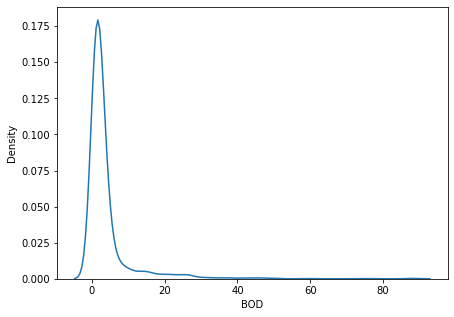

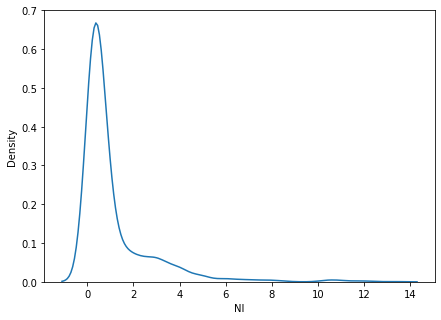

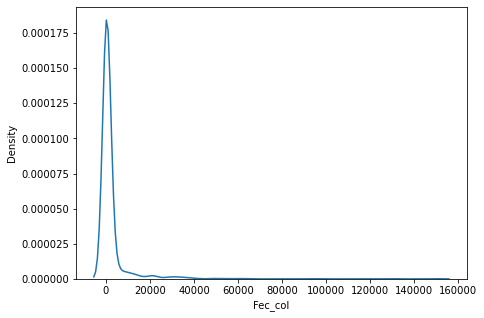

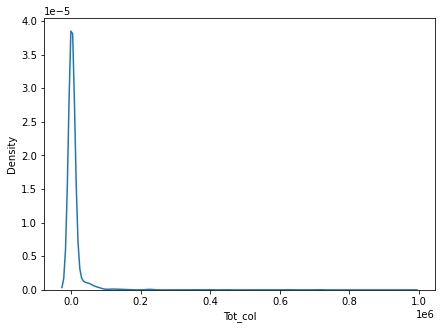

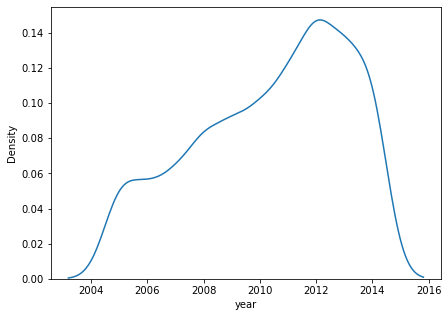

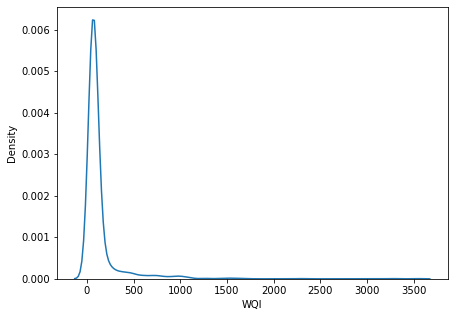

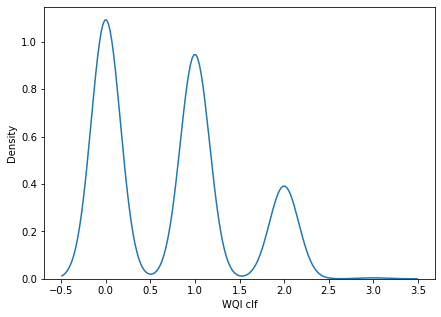

In [39]:
plot_kde(df_wqi.select_dtypes(exclude="object"))

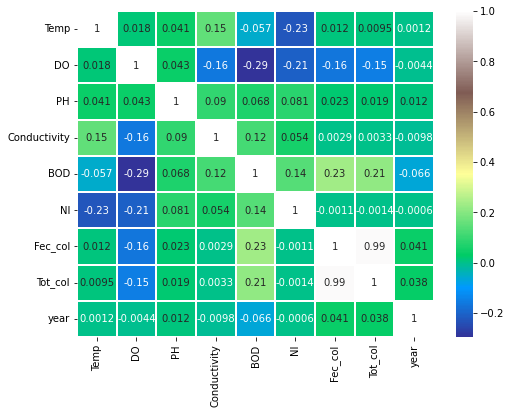

In [38]:
# create a correlation heatmap
sns.heatmap(df.corr(),annot=True, cmap='terrain', linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()


In [37]:
df_wqi.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,26.241931,6.432263,7.228045,1006.325691,3.961788,1.119716,2264.420646,7242.598876,2010.380337,130.303409,0.715169
std,3.231044,1.258875,0.582761,2764.600752,7.130494,1.629483,8259.474360,40230.193629,2.704223,222.261326,0.731754
min,10.000000,0.000000,2.900000,11.000000,0.100000,0.000000,0.000000,0.000000,2005.000000,16.795814,0.000000
25%,25.000000,6.000000,6.900000,83.000000,1.100000,0.263000,46.000000,108.750000,2008.000000,54.641036,0.000000
50%,27.000000,6.700000,7.224500,183.000000,1.800000,0.520000,233.000000,465.000000,2011.000000,69.840286,1.000000
75%,28.200000,7.200000,7.600000,489.250000,3.400000,1.100000,672.500000,1650.000000,2013.000000,94.348696,1.000000
max,35.000000,10.000000,9.010000,18569.000000,88.000000,13.200000,150250.000000,967500.000000,2014.000000,3524.421534,3.000000


In [38]:
features = list(df_wqi.columns)[3:11]
data_f = df_wqi[features]
data_f.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,26.241931,6.432263,7.228045,1006.325691,3.961788,1.119716,2264.420646,7242.598876
std,3.231044,1.258875,0.582761,2764.600752,7.130494,1.629483,8259.474360,40230.193629
min,10.000000,0.000000,2.900000,11.000000,0.100000,0.000000,0.000000,0.000000
25%,25.000000,6.000000,6.900000,83.000000,1.100000,0.263000,46.000000,108.750000
50%,27.000000,6.700000,7.224500,183.000000,1.800000,0.520000,233.000000,465.000000
75%,28.200000,7.200000,7.600000,489.250000,3.400000,1.100000,672.500000,1650.000000
max,35.000000,10.000000,9.010000,18569.000000,88.000000,13.200000,150250.000000,967500.000000


In [39]:
features = list(df_wqi.columns)[:]
data_cluster = df_wqi['WQI clf']
data_cluster.describe()

count    1780.000000
mean        0.715169
std         0.731754
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: WQI clf, dtype: float64

In [40]:
data_f

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
0,30.6,6.7,7.50,203.0,1.8965,0.100,11.0,27.0
1,29.8,5.7,7.20,189.0,2.0000,0.200,4953.0,8391.0
2,29.5,6.3,6.90,179.0,1.7000,0.100,3243.0,5330.0
3,29.7,5.8,6.90,64.0,3.8000,0.500,5382.0,8443.0
4,29.5,5.8,7.30,83.0,1.9000,0.400,3428.0,5500.0
...,...,...,...,...,...,...,...,...
1780,27.0,7.4,7.00,88.5,0.9770,0.186,27.0,105.0
1781,27.0,6.6,7.81,603.2,2.6750,0.263,40.0,191.0
1782,28.0,6.6,7.49,571.5,2.0910,0.256,151.0,273.0
1783,28.0,5.4,7.16,75.8,2.0920,0.520,404.0,513.0


In [41]:
Y = data_cluster

In [42]:
features = list(df_wqi.columns)[3:11]
X = df_wqi[features]
X.describe()
X.dtypes

Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
dtype: object

In [43]:
from sklearn.preprocessing import StandardScaler
# perform feature scaling on a dataset X,  for normalization.  map data b/w 0 and 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.34919038,  0.21273941,  0.46679752, ..., -0.62596683,
        -0.27290525, -0.1794082 ],
       [ 1.10152283, -0.58184389, -0.04813777, ..., -0.56458042,
         0.32560606,  0.02855377],
       [ 1.0086475 , -0.10509391, -0.56307306, ..., -0.62596683,
         0.11851291, -0.04755474],
       ...,
       [ 0.54427084,  0.13328108,  0.44963301, ..., -0.53020403,
        -0.25595025, -0.17329167],
       [ 0.54427084, -0.82021888, -0.11679581, ..., -0.36814393,
        -0.22531016, -0.16732433],
       [ 1.16343972, -0.82021888,  0.24365889, ..., -0.55537246,
        -0.21901259, -0.16623031]])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

# random_state allows you to reproduce the same results across different runs of your code, making your experiments more 
# reproducible and results more reliable

## Now Apply Machine Learning Algorithms

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


### Logistic Regression

In [51]:
# Logistic Regression

# Data Pre-processing Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modelling Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, classification_report

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
logistic_predictions = logistic_model.predict(X_test)

# Calculate precision score and print classification report
logistic_precision = precision_score(y_test, logistic_predictions, average='macro')
print(classification_report(y_test, logistic_predictions, zero_division=1))


              precision    recall  f1-score   support

           0       0.90      0.71      0.79       162
           1       0.52      0.92      0.66       130
           2       1.00      0.00      0.00        63
           3       1.00      0.00      0.00         1

    accuracy                           0.66       356
   macro avg       0.86      0.41      0.36       356
weighted avg       0.78      0.66      0.60       356



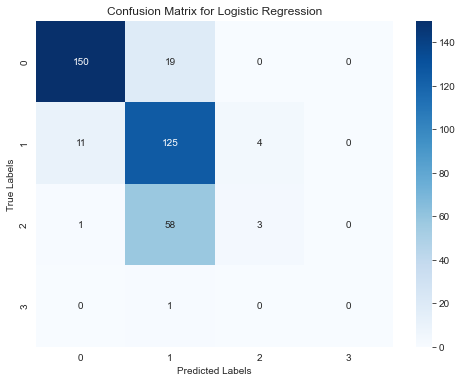

In [84]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, logistic_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=logistic_model.classes_, yticklabels=logistic_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [52]:
# Additional Libraries
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
logistic_predictions_bin = label_binarize(logistic_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
logistic_roc_auc = roc_auc_score(y_test_bin, logistic_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", logistic_roc_auc)


ROC AUC Score:  0.6344937455450487


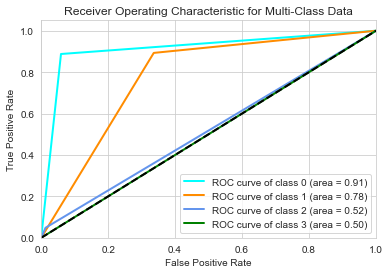

In [86]:
# Additional Libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], logistic_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


### Support Vector Machine

In [53]:
# SVM
# Modelling Libraries
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Make predictions on the test data
svm_predictions = svm_model.predict(X_test)

# Calculate precision score and print classification report
svm_precision = precision_score(y_test, svm_predictions, average='macro')

print(classification_report(y_test, svm_predictions, zero_division=1))


              precision    recall  f1-score   support

           0       0.93      0.34      0.50       162
           1       0.42      0.97      0.59       130
           2       1.00      0.00      0.00        63
           3       1.00      0.00      0.00         1

    accuracy                           0.51       356
   macro avg       0.84      0.33      0.27       356
weighted avg       0.76      0.51      0.44       356



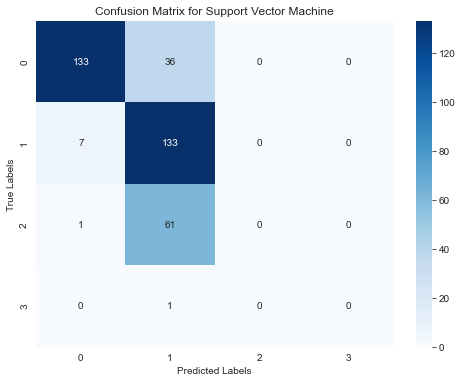

In [88]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, svm_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()


In [89]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
svm_predictions_bin = label_binarize(svm_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
svm_roc_auc = roc_auc_score(y_test_bin, svm_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", svm_roc_auc)

ROC AUC Score:  0.6593949485527735


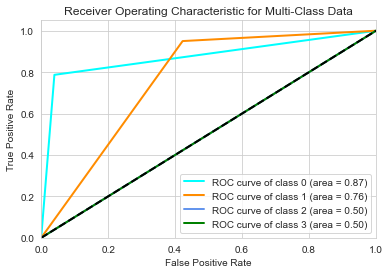

In [90]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], svm_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


### Decision Tree

In [50]:
# DT
# Modelling Libraries
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Make predictions on the test data
dt_predictions = dt_model.predict(X_test)

# Calculate precision score and print classification report
dt_precision = precision_score(y_test, dt_predictions, average='macro')
print(classification_report(y_test, dt_predictions, zero_division=1))


              precision    recall  f1-score   support

           0       0.90      0.91      0.90       197
           1       0.85      0.87      0.86       166
           2       0.86      0.79      0.83        81
           3       1.00      0.00      0.00         1

    accuracy                           0.87       445
   macro avg       0.90      0.64      0.65       445
weighted avg       0.87      0.87      0.87       445



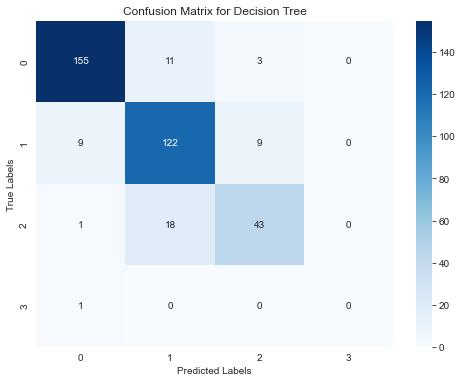

In [92]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


In [93]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
dt_predictions_bin = label_binarize(dt_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
dt_roc_auc = roc_auc_score(y_test_bin, dt_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", dt_roc_auc)

ROC AUC Score:  0.7830299815376718


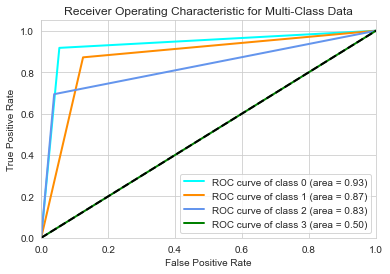

In [94]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], dt_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


### K-Nearest Neighbors

In [51]:
# KNN
# Modelling Libraries
from sklearn.neighbors import KNeighborsClassifier

# Define the value of k
k = 5

# Initialize and train the KNN model with k=5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Make predictions on the test data
knn_predictions = knn_model.predict(X_test)

# Calculate precision score and print classification report
knn_precision = precision_score(y_test, knn_predictions, average='macro')
print(classification_report(y_test, knn_predictions, zero_division=1))


              precision    recall  f1-score   support

           0       0.87      0.79      0.83       197
           1       0.69      0.81      0.74       166
           2       0.73      0.63      0.68        81
           3       1.00      0.00      0.00         1

    accuracy                           0.77       445
   macro avg       0.82      0.56      0.56       445
weighted avg       0.78      0.77      0.77       445



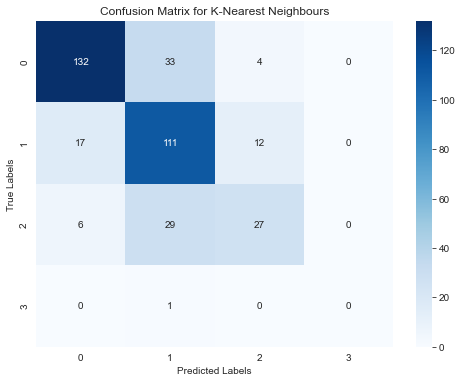

In [96]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, knn_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for K-Nearest Neighbours')
plt.show()


In [97]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
knn_predictions_bin = label_binarize(knn_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
knn_roc_auc = roc_auc_score(y_test_bin, knn_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", knn_roc_auc)

ROC AUC Score:  0.6966176228259633


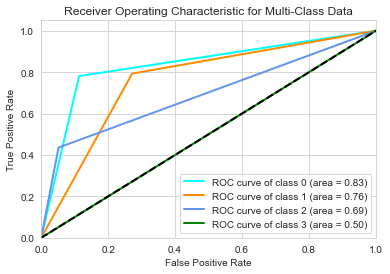

In [98]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], knn_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


### RandomForest

In [52]:
# RF
# Modelling Libraries
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = rf_model.predict(X_test)

# Calculate precision score and print classification report
rf_precision = precision_score(y_test, rf_predictions, average='macro')

print(classification_report(y_test, rf_predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       197
           1       0.84      0.95      0.89       166
           2       0.94      0.83      0.88        81
           3       1.00      0.00      0.00         1

    accuracy                           0.91       445
   macro avg       0.94      0.67      0.68       445
weighted avg       0.92      0.91      0.91       445



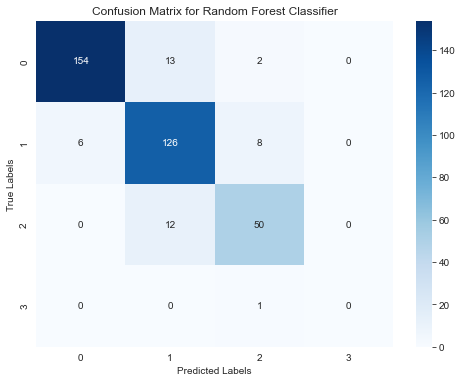

In [100]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


In [101]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rf_predictions_bin = label_binarize(rf_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
rf_roc_auc = roc_auc_score(y_test_bin, rf_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", rf_roc_auc)

ROC AUC Score:  0.8056118843187274


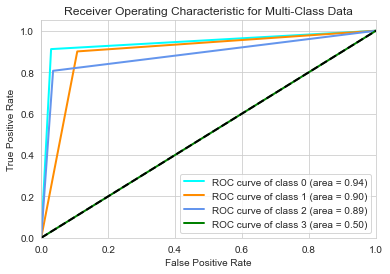

In [102]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


## CatBoost

In [53]:
import catboost as cb
# CatBoost specifically designed for handling categorical features in tabular data. 
# Initialize and train the CatBoost model with specified parameters
catboost_model = cb.CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=2, loss_function='MultiClass')
# depth: This parameter specifies the maximum depth of each tree in the ensemble
# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions on the test data
catboost_predictions = catboost_model.predict(X_test)

# Calculate precision score and print classification report
catboost_precision = precision_score(y_test, catboost_predictions, average='macro')
print("CatBoost Precision Score:", catboost_precision)
print(classification_report(y_test, catboost_predictions, zero_division=1))


0:	learn: 1.2547521	total: 184ms	remaining: 3m 3s
1:	learn: 1.1635003	total: 189ms	remaining: 1m 34s
2:	learn: 1.0871308	total: 195ms	remaining: 1m 4s
3:	learn: 1.0243022	total: 200ms	remaining: 49.7s
4:	learn: 0.9778087	total: 205ms	remaining: 40.8s
5:	learn: 0.9333060	total: 210ms	remaining: 34.8s
6:	learn: 0.8941686	total: 215ms	remaining: 30.5s
7:	learn: 0.8594785	total: 218ms	remaining: 27s
8:	learn: 0.8277135	total: 220ms	remaining: 24.2s
9:	learn: 0.7981623	total: 222ms	remaining: 22s
10:	learn: 0.7696947	total: 225ms	remaining: 20.2s
11:	learn: 0.7475560	total: 227ms	remaining: 18.7s
12:	learn: 0.7297552	total: 229ms	remaining: 17.4s
13:	learn: 0.7119412	total: 231ms	remaining: 16.3s
14:	learn: 0.6972913	total: 233ms	remaining: 15.3s
15:	learn: 0.6811891	total: 235ms	remaining: 14.5s
16:	learn: 0.6669621	total: 237ms	remaining: 13.7s
17:	learn: 0.6472022	total: 239ms	remaining: 13.1s
18:	learn: 0.6354526	total: 241ms	remaining: 12.5s
19:	learn: 0.6224881	total: 244ms	remaining:

210:	learn: 0.2861146	total: 680ms	remaining: 2.54s
211:	learn: 0.2850344	total: 683ms	remaining: 2.54s
212:	learn: 0.2844553	total: 685ms	remaining: 2.53s
213:	learn: 0.2842311	total: 688ms	remaining: 2.52s
214:	learn: 0.2837931	total: 690ms	remaining: 2.52s
215:	learn: 0.2835104	total: 692ms	remaining: 2.51s
216:	learn: 0.2830407	total: 695ms	remaining: 2.51s
217:	learn: 0.2819226	total: 697ms	remaining: 2.5s
218:	learn: 0.2812031	total: 700ms	remaining: 2.49s
219:	learn: 0.2804457	total: 702ms	remaining: 2.49s
220:	learn: 0.2794164	total: 704ms	remaining: 2.48s
221:	learn: 0.2786535	total: 707ms	remaining: 2.48s
222:	learn: 0.2784534	total: 710ms	remaining: 2.47s
223:	learn: 0.2782596	total: 712ms	remaining: 2.47s
224:	learn: 0.2781497	total: 715ms	remaining: 2.46s
225:	learn: 0.2780439	total: 717ms	remaining: 2.45s
226:	learn: 0.2776532	total: 719ms	remaining: 2.45s
227:	learn: 0.2774754	total: 721ms	remaining: 2.44s
228:	learn: 0.2770929	total: 723ms	remaining: 2.43s
229:	learn: 0

421:	learn: 0.2183571	total: 1.17s	remaining: 1.6s
422:	learn: 0.2181345	total: 1.17s	remaining: 1.6s
423:	learn: 0.2176984	total: 1.17s	remaining: 1.59s
424:	learn: 0.2172606	total: 1.18s	remaining: 1.59s
425:	learn: 0.2171257	total: 1.18s	remaining: 1.59s
426:	learn: 0.2170679	total: 1.18s	remaining: 1.58s
427:	learn: 0.2164890	total: 1.18s	remaining: 1.58s
428:	learn: 0.2164030	total: 1.18s	remaining: 1.58s
429:	learn: 0.2163102	total: 1.19s	remaining: 1.57s
430:	learn: 0.2161370	total: 1.19s	remaining: 1.57s
431:	learn: 0.2158470	total: 1.19s	remaining: 1.57s
432:	learn: 0.2157200	total: 1.2s	remaining: 1.56s
433:	learn: 0.2155541	total: 1.2s	remaining: 1.56s
434:	learn: 0.2151122	total: 1.2s	remaining: 1.56s
435:	learn: 0.2149850	total: 1.2s	remaining: 1.56s
436:	learn: 0.2149373	total: 1.24s	remaining: 1.6s
437:	learn: 0.2148191	total: 1.25s	remaining: 1.6s
438:	learn: 0.2147357	total: 1.25s	remaining: 1.6s
439:	learn: 0.2146175	total: 1.25s	remaining: 1.6s
440:	learn: 0.2145415	

635:	learn: 0.1832663	total: 1.69s	remaining: 970ms
636:	learn: 0.1829928	total: 1.7s	remaining: 967ms
637:	learn: 0.1829357	total: 1.7s	remaining: 964ms
638:	learn: 0.1827434	total: 1.7s	remaining: 961ms
639:	learn: 0.1825787	total: 1.7s	remaining: 958ms
640:	learn: 0.1824183	total: 1.71s	remaining: 955ms
641:	learn: 0.1822838	total: 1.71s	remaining: 953ms
642:	learn: 0.1821319	total: 1.71s	remaining: 950ms
643:	learn: 0.1820775	total: 1.71s	remaining: 948ms
644:	learn: 0.1818513	total: 1.72s	remaining: 945ms
645:	learn: 0.1817916	total: 1.72s	remaining: 944ms
646:	learn: 0.1817294	total: 1.73s	remaining: 942ms
647:	learn: 0.1816383	total: 1.73s	remaining: 939ms
648:	learn: 0.1813259	total: 1.73s	remaining: 937ms
649:	learn: 0.1812468	total: 1.74s	remaining: 934ms
650:	learn: 0.1811559	total: 1.74s	remaining: 931ms
651:	learn: 0.1810692	total: 1.74s	remaining: 928ms
652:	learn: 0.1809623	total: 1.74s	remaining: 926ms
653:	learn: 0.1808270	total: 1.74s	remaining: 923ms
654:	learn: 0.18

865:	learn: 0.1570457	total: 2.2s	remaining: 340ms
866:	learn: 0.1569988	total: 2.2s	remaining: 338ms
867:	learn: 0.1569292	total: 2.2s	remaining: 335ms
868:	learn: 0.1568934	total: 2.21s	remaining: 333ms
869:	learn: 0.1568600	total: 2.21s	remaining: 330ms
870:	learn: 0.1568166	total: 2.21s	remaining: 327ms
871:	learn: 0.1567792	total: 2.21s	remaining: 325ms
872:	learn: 0.1567110	total: 2.22s	remaining: 322ms
873:	learn: 0.1566144	total: 2.22s	remaining: 320ms
874:	learn: 0.1565629	total: 2.22s	remaining: 317ms
875:	learn: 0.1565235	total: 2.22s	remaining: 315ms
876:	learn: 0.1563765	total: 2.23s	remaining: 312ms
877:	learn: 0.1563418	total: 2.23s	remaining: 310ms
878:	learn: 0.1562771	total: 2.23s	remaining: 307ms
879:	learn: 0.1562236	total: 2.23s	remaining: 304ms
880:	learn: 0.1559760	total: 2.23s	remaining: 302ms
881:	learn: 0.1559367	total: 2.24s	remaining: 299ms
882:	learn: 0.1556529	total: 2.24s	remaining: 297ms
883:	learn: 0.1555150	total: 2.24s	remaining: 294ms
884:	learn: 0.1

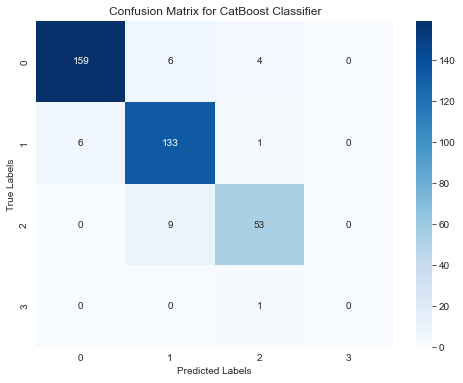

In [104]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, catboost_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=catboost_model.classes_, yticklabels=catboost_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CatBoost Classifier')
plt.show()


In [105]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
catboost_predictions_bin = label_binarize(catboost_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
ct_roc_auc = roc_auc_score(y_test_bin, catboost_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", ct_roc_auc)

ROC AUC Score:  0.8290125563343134


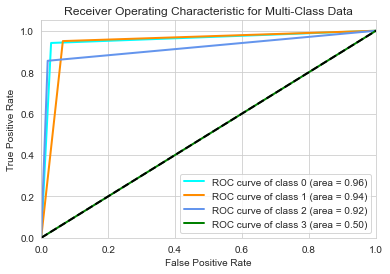

In [106]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], catboost_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


## XGBoost Classifier

In [54]:
# XGBoost Classifier Extreme Gradient Boosting
# XGBoost is based on the gradient boosting framework, which builds an ensemble of weak learners (typically decision trees) 
# sequentially, with each new learner focusing on the mistakes made by the previous ones. This iterative process leads to a 
# strong predictive model.
from xgboost import XGBClassifier

# Initialize and train the XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
xgb_predictions = xgb_model.predict(X_test)

# Calculate precision score and print classification report
xgb_precision = precision_score(y_test, xgb_predictions, average='macro')
print(classification_report(y_test, xgb_predictions, zero_division=1))

# Calculate probabilities for ROC AUC
xgb_probabilities = xgb_model.predict_proba(X_test)



              precision    recall  f1-score   support

           0       0.96      0.92      0.94       197
           1       0.87      0.96      0.91       166
           2       0.95      0.85      0.90        81
           3       1.00      0.00      0.00         1

    accuracy                           0.92       445
   macro avg       0.94      0.68      0.69       445
weighted avg       0.92      0.92      0.92       445



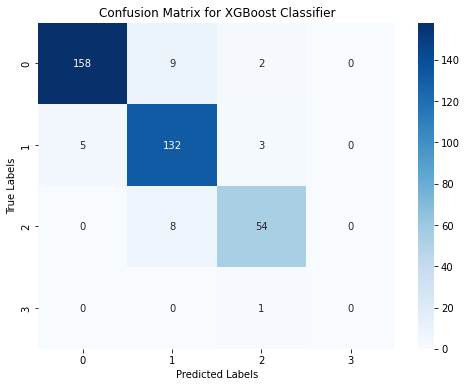

In [238]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()


In [108]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
xgb_predictions_bin = label_binarize(xgb_predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
xgb_roc_auc = roc_auc_score(y_test_bin, xgb_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", xgb_roc_auc)

ROC AUC Score:  0.8289343605932016


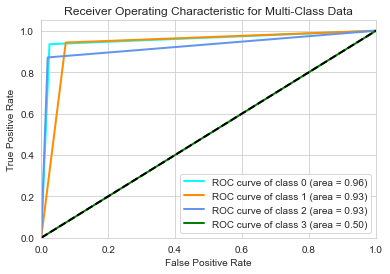

In [109]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


In [55]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical


# Data preprocessing (scaling and one-hot encoding)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert target variable to one-hot encoding
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Define the model architecture
model = Sequential() # It is used to build neural network models layer by layer in a sequential manner, where each layer 
                     # flows sequentially from the input to the output.
model.add(Dense(64, activation='relu', input_shape=(8,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Dense(4) Output layer with 4 units for 4 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f'Test accuracy: {accuracy}')


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4004 - loss: 1.3029 - val_accuracy: 0.6330 - val_loss: 0.9886
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6412 - loss: 0.9415 - val_accuracy: 0.7116 - val_loss: 0.7695
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6988 - loss: 0.7618 - val_accuracy: 0.7378 - val_loss: 0.6665
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7379 - loss: 0.6747 - val_accuracy: 0.7341 - val_loss: 0.6164
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7368 - loss: 0.6406 - val_accuracy: 0.7528 - val_loss: 0.5709
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7430 - loss: 0.6012 - val_accuracy: 0.7566 - val_loss: 0.5428
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7463 - loss: 0.5904 - val_accuracy: 0.7603 - val_loss: 0.5108
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7895 - loss: 0.5375 - val_accuracy: 0.7753 - val_loss

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


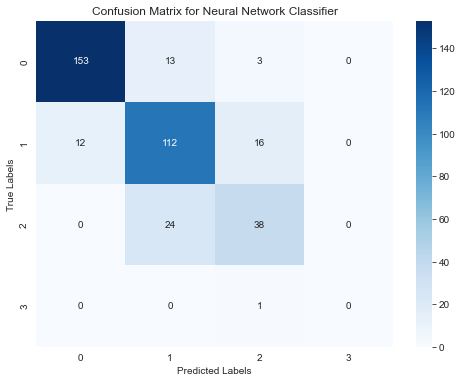

In [111]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Convert true labels to class labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(4), yticklabels=np.arange(4))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Network Classifier')
plt.show()

In [112]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
ann_predictions_bin = label_binarize(y_pred_classes, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
ann_roc_auc = roc_auc_score(y_test_bin, ann_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", ann_roc_auc)

ROC AUC Score:  0.7543895601809844


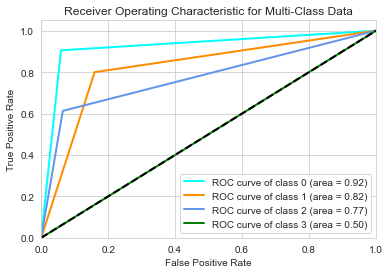

In [113]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], ann_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


## ENSEMBLE Method

### Random Forest and CatBoost Classifier

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=30)
# Base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=False)

# Meta classifier
meta_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=False)

# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[('rf', rf_classifier), ('catboost', catboost_classifier)],
    final_estimator=meta_classifier,
    cv=5  # The cv (Cross-Validation) parameter specifies the number of folds for cross-validation.
)

# Training the stacking classifier
stacking_classifier.fit(X_train, y_train)

# Predictions
predictions = stacking_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9410112359550562


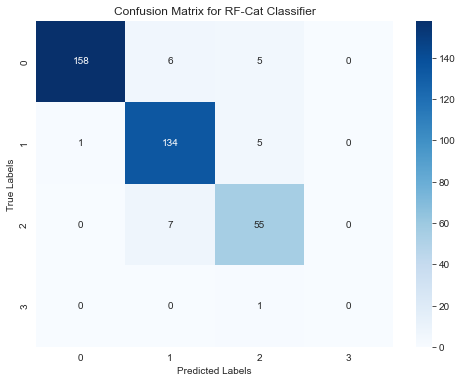

In [117]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=stacking_classifier.classes_, yticklabels=stacking_classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for RF-Cat Classifier')
plt.show()


In [118]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rf_cat_predictions_bin = label_binarize(predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
rfct_roc_auc = roc_auc_score(y_test_bin, rf_cat_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", rfct_roc_auc)

ROC AUC Score:  0.8353383014799012


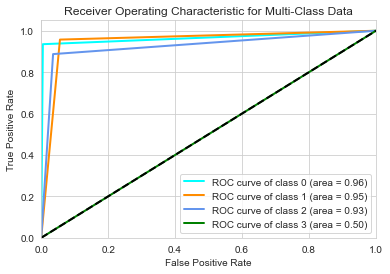

In [119]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_cat_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


### Random Forest , CatBoost and MLPClassifier

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=30)

# Base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=False)
ann_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Meta classifier
meta_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[('rf', rf_classifier), ('catboost', catboost_classifier), ('ann', ann_classifier)],
    final_estimator=meta_classifier,
    cv=5 # The cv (Cross-Validation) parameter specifies the number of folds for cross-validation.
)

# Training the stacking classifier
stacking_classifier.fit(X_train, y_train)

# Predictions
predictions = stacking_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9634831460674157


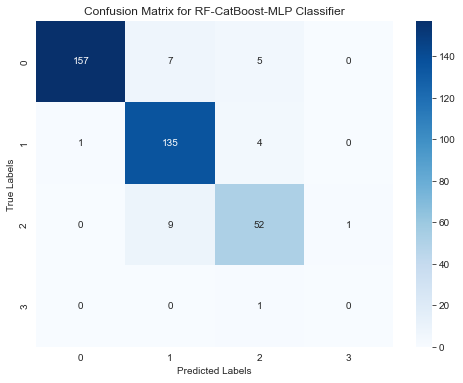

In [125]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=stacking_classifier.classes_, yticklabels=stacking_classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for RF-CatBoost-MLP Classifier')
plt.savefig('RF-CatBoost-MLP Classifier.png', bbox_inches='tight') 
plt.show()


In [126]:
# Binarize the output classes for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
rf_cat_ann_predictions_bin = label_binarize(predictions, classes=[0, 1, 2, 3])

# Calculate ROC AUC score
rfctann_roc_auc = roc_auc_score(y_test_bin, rf_cat_ann_predictions_bin, average='macro', multi_class='ovr')

print("ROC AUC Score: ", rfctann_roc_auc)

ROC AUC Score:  0.827893045827957


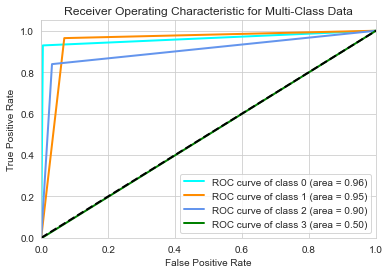

In [127]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_cat_ann_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.savefig('RF-CatBoost-MLP Classifier (AUC).png',  bbox_inches='tight') 
plt.show()


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are your training and testing data

# Train Logistic Regression classifier
log_reg_classifier = LogisticRegression(random_state=42)
log_reg_classifier.fit(X_train, y_train)

# Train Artificial Neural Network (ANN) model
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann_model.fit(X_train, y_train)

# Define the meta-model
meta_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Combine classifiers in stacking classifier
stacking_classifier3 = StackingClassifier(
    estimators=[('ann', ann_model), ('log_reg', log_reg_classifier)],
    final_estimator=meta_classifier,
    cv=5
)

# Training the stacking classifier
stacking_classifier3.fit(X_train, y_train)

# Predictions
predictions3 = stacking_classifier3.predict(X_test)


# Calculate precision score and print classification report
predictions3_precision = precision_score(y_test, predictions3, average='macro')
print(classification_report(y_test, predictions3, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       162
           1       0.95      0.99      0.97       130
           2       0.94      0.97      0.95        63
           3       1.00      0.00      0.00         1

    accuracy                           0.97       356
   macro avg       0.97      0.73      0.73       356
weighted avg       0.97      0.97      0.97       356

